In [5]:
import os
import matplotlib.pyplot as plt
import random
import numpy as np
from math import log10, sqrt
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image, ImageFilter
from keras_tuner import Objective
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

AUTOTUNE = tf.data.AUTOTUNE

## EDA of the Dataset

In [4]:
# Define the paths to the directories
dataset_path = "./dataset/"
train_hr_path = os.path.join(dataset_path, "train_hr")
train_lr_path = os.path.join(dataset_path, "train_lr")
val_hr_path = os.path.join(dataset_path, "val_hr")
val_lr_path = os.path.join(dataset_path, "val_lr")
test_hr_path = os.path.join(dataset_path, "test_hr")
test_lr_path = os.path.join(dataset_path, "test_lr")

# Count the number of images in each directory
def count_images(directory):
    return len([file for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))])

# Store the counts in a dictionary
image_counts = {
    "Total Dataset": sum(count_images(path) for path in [train_hr_path, train_lr_path, val_hr_path, val_lr_path, test_hr_path, test_lr_path]),
    "Train HR": count_images(train_hr_path),
    "Train LR": count_images(train_lr_path),
    "Validation HR": count_images(val_hr_path),
    "Validation LR": count_images(val_lr_path),
    "Test HR": count_images(test_hr_path),
    "Test LR": count_images(test_lr_path)
}

image_counts

{'Total Dataset': 2822,
 'Train HR': 942,
 'Train LR': 942,
 'Validation HR': 218,
 'Validation LR': 218,
 'Test HR': 251,
 'Test LR': 251}

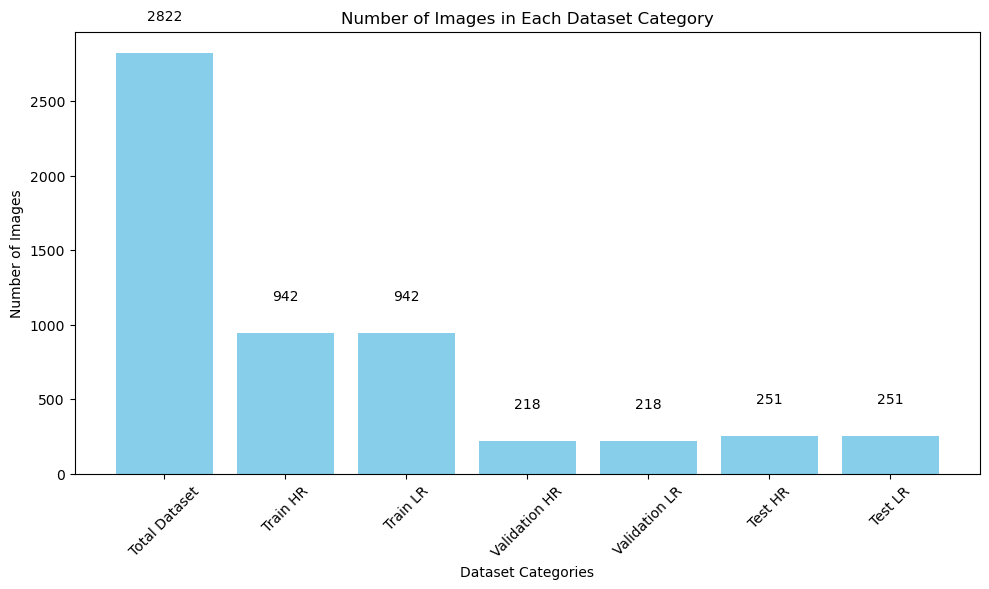

In [7]:
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color='skyblue')

# Adding annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 200, int(yval), ha='center', va='bottom')

plt.xlabel('Dataset Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Dataset Category')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

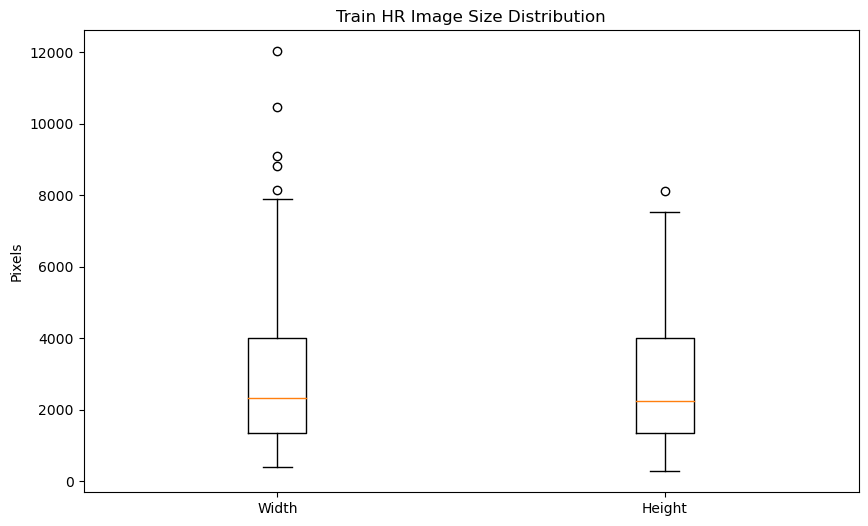

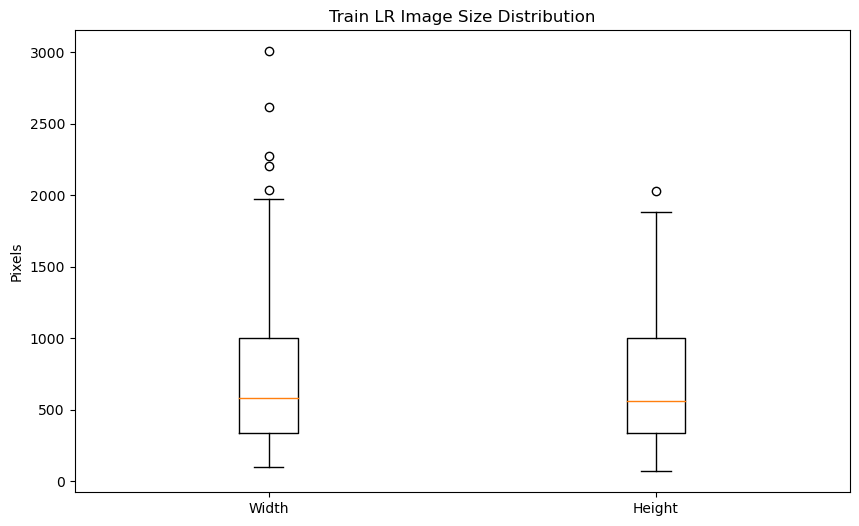

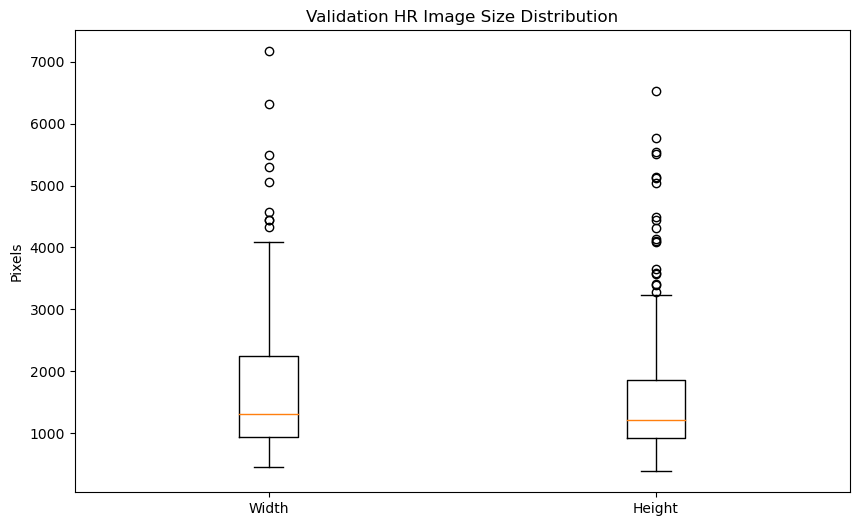

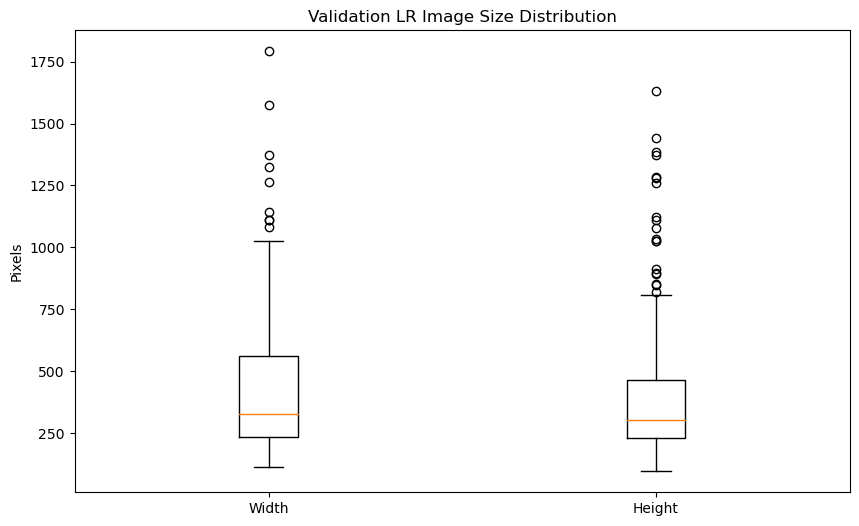

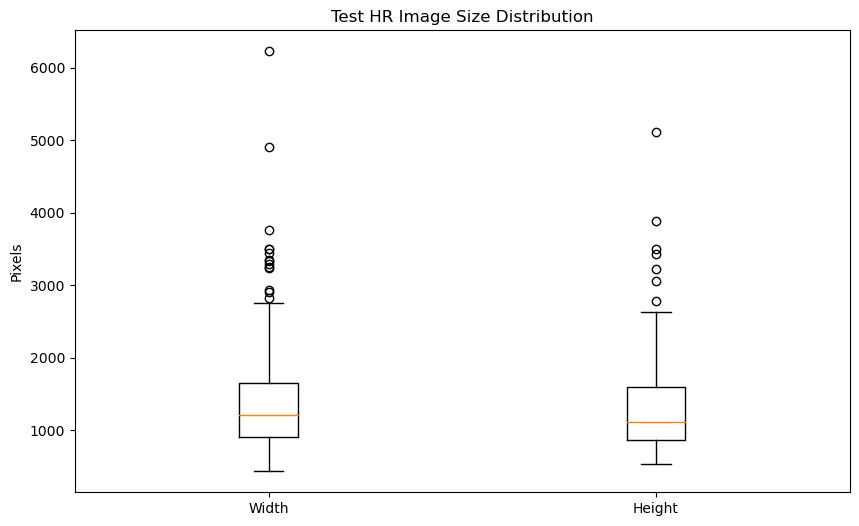

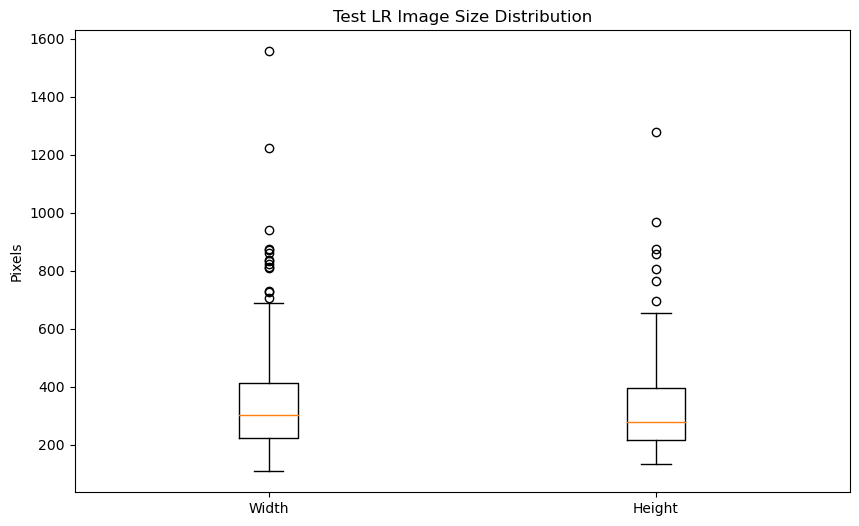

In [11]:
# Plotting image size distribution with boxplot
def plot_image_size_boxplot(sizes, title):
    widths, heights = zip(*sizes)
    plt.figure(figsize=(10, 6))
    plt.boxplot([widths, heights], labels=['Width', 'Height'])
    plt.title(title)
    plt.ylabel('Pixels')
    plt.show()

plot_image_size_boxplot(train_hr_sizes, 'Train HR Image Size Distribution')
plot_image_size_boxplot(train_lr_sizes, 'Train LR Image Size Distribution')
plot_image_size_boxplot(val_hr_sizes, 'Validation HR Image Size Distribution')
plot_image_size_boxplot(val_lr_sizes, 'Validation LR Image Size Distribution')
plot_image_size_boxplot(test_hr_sizes, 'Test HR Image Size Distribution')
plot_image_size_boxplot(test_lr_sizes, 'Test LR Image Size Distribution')


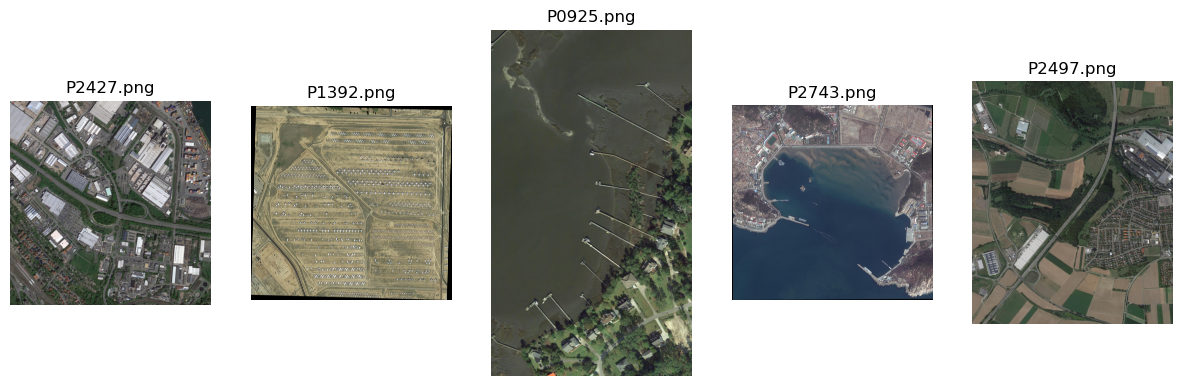

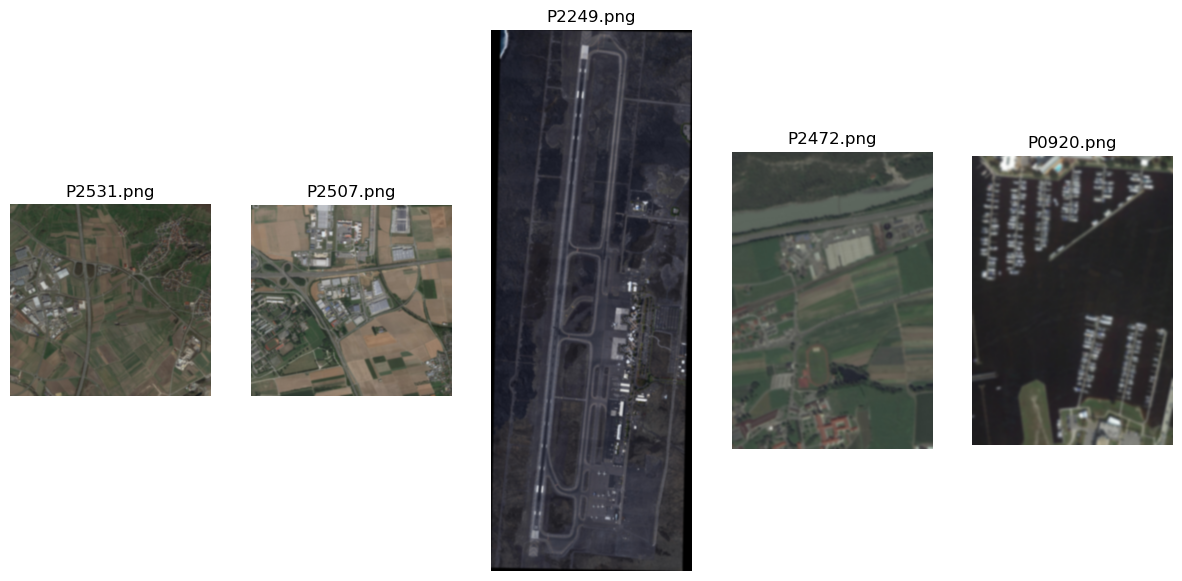

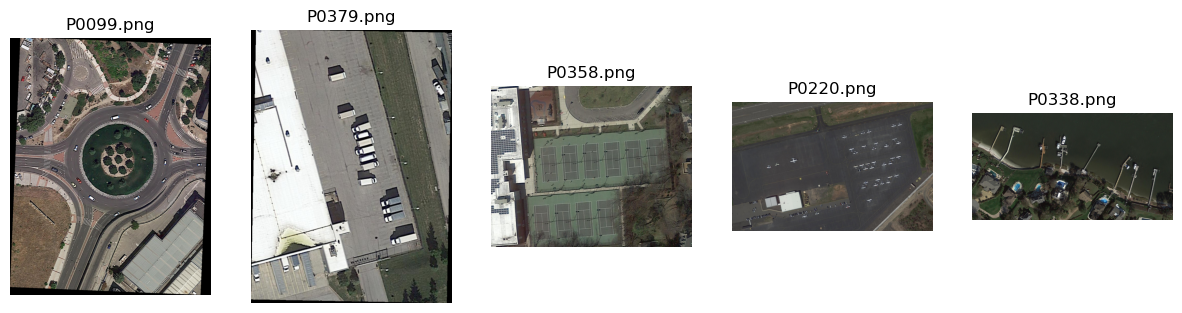

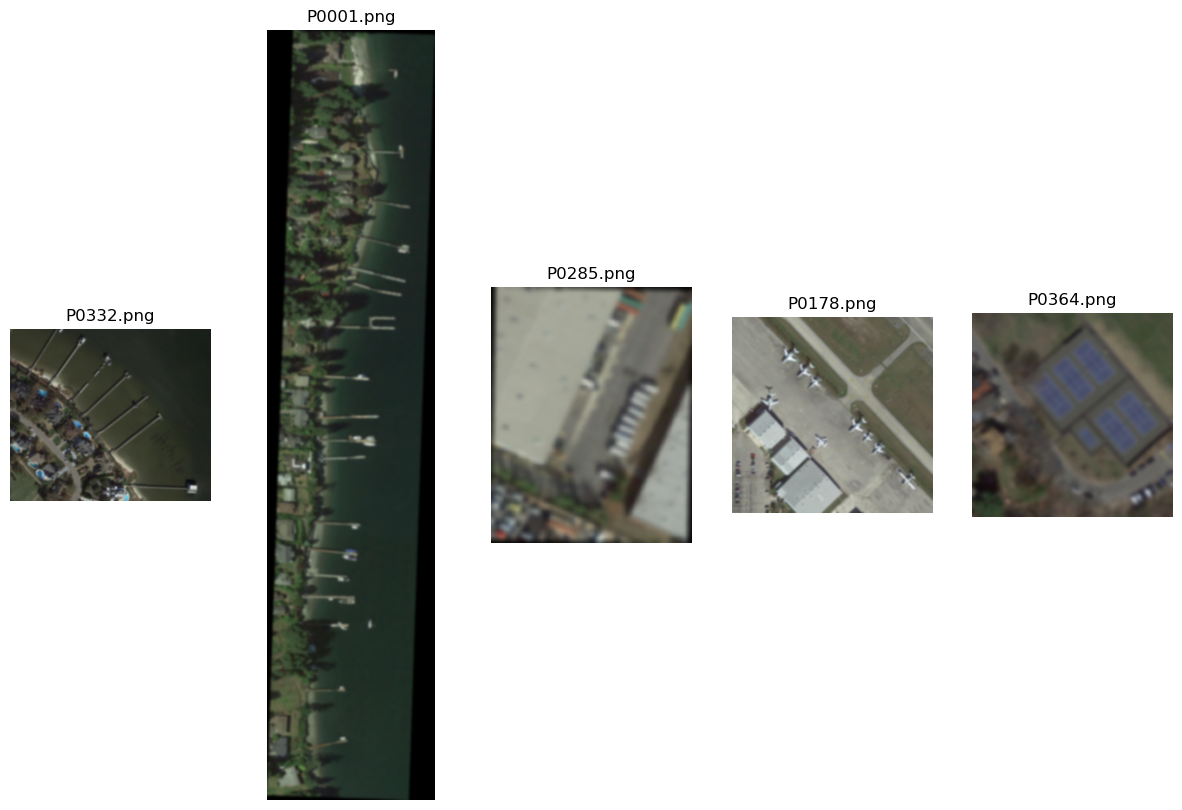

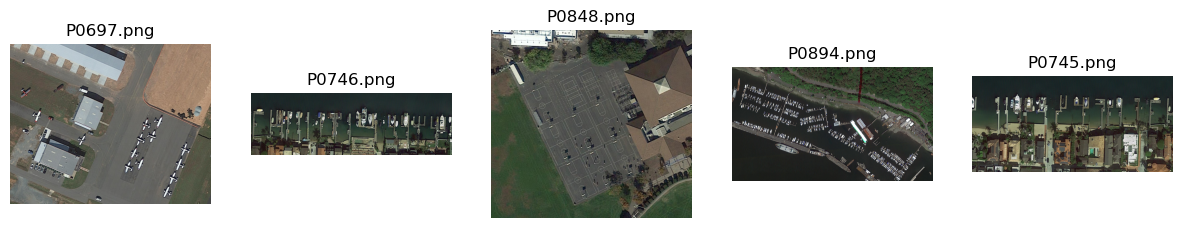

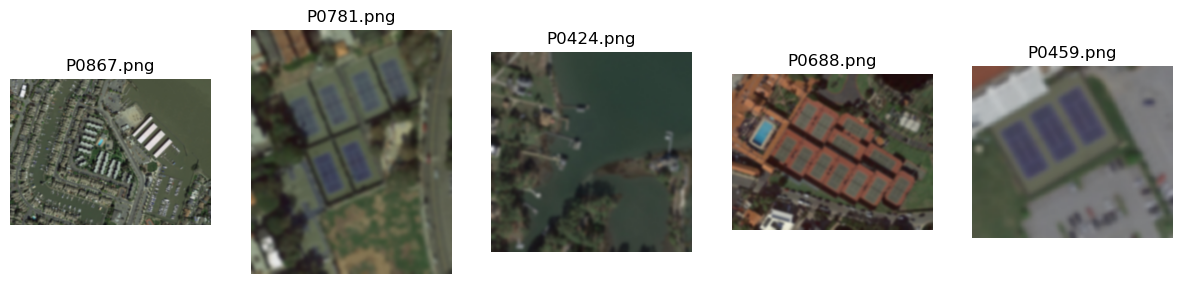

In [10]:
# Function to display sample images
def display_sample_images(directory, n=5):
    sample_files = random.sample([file for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))], n)
    plt.figure(figsize=(15, 10))
    for i, file in enumerate(sample_files):
        with Image.open(os.path.join(directory, file)) as img:
            plt.subplot(1, n, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(file)
    plt.show()

display_sample_images(train_hr_path, n=5)
display_sample_images(train_lr_path, n=5)
display_sample_images(val_hr_path, n=5)
display_sample_images(val_lr_path, n=5)
display_sample_images(test_hr_path, n=5)
display_sample_images(test_lr_path, n=5)


### Color Channel Analysis

### Correlation between HR and LR images

In [27]:

# Function to calculate pixel intensity correlation
def calculate_correlation(hr_directory, lr_directory, n=10):
    correlations = []
    hr_files = random.sample([file for file in os.listdir(hr_directory) if os.path.isfile(os.path.join(hr_directory, file))], n)
    for file in hr_files:
        with Image.open(os.path.join(hr_directory, file)) as hr_img, Image.open(os.path.join(lr_directory, file)) as lr_img:
            hr_img_array = np.array(hr_img)
            lr_img_resized = lr_img.resize(hr_img.size, Image.BICUBIC)
            lr_img_array = np.array(lr_img_resized)
            hr_img_flat = hr_img_array.flatten()
            lr_img_flat = lr_img_array.flatten()
            correlation = np.corrcoef(hr_img_flat, lr_img_flat)[0, 1]
            correlations.append(correlation)
    return np.mean(correlations)

average_correlation = calculate_correlation(train_hr_path, train_lr_path)
print(f'Average correlation between HR and LR images: {average_correlation}')


Average correlation between HR and LR images: 0.8505911157889638


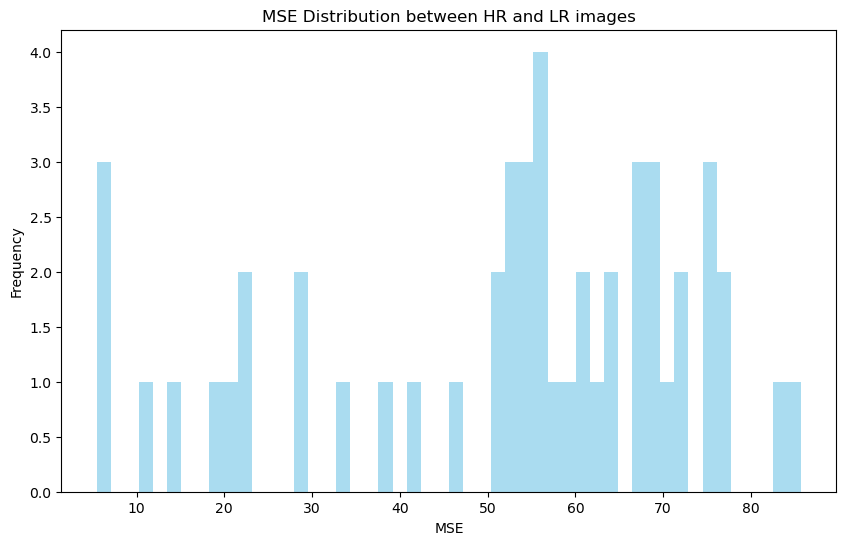

In [28]:
# Function to calculate MSE
def calculate_mse(hr_image, lr_image):
    mse = np.mean((hr_image - lr_image) ** 2)
    return mse

# Function to get MSE distribution for a set of images
def get_mse_distribution(hr_directory, lr_directory, n=50):
    mses = []
    hr_files = random.sample([file for file in os.listdir(hr_directory) if os.path.isfile(os.path.join(hr_directory, file))], n)
    for file in hr_files:
        with Image.open(os.path.join(hr_directory, file)) as hr_img, Image.open(os.path.join(lr_directory, file)) as lr_img:
            hr_img_array = np.array(hr_img)
            lr_img_resized = lr_img.resize(hr_img.size, Image.BICUBIC)
            lr_img_array = np.array(lr_img_resized)
            mse = calculate_mse(hr_img_array, lr_img_array)
            mses.append(mse)
    return mses

mse_distribution = get_mse_distribution(train_hr_path, train_lr_path)
plt.figure(figsize=(10, 6))
plt.hist(mse_distribution, bins=50, color='skyblue', alpha=0.7)
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title('MSE Distribution between HR and LR images')
plt.show()


### Visual comparison of quality difference between HR and LR image

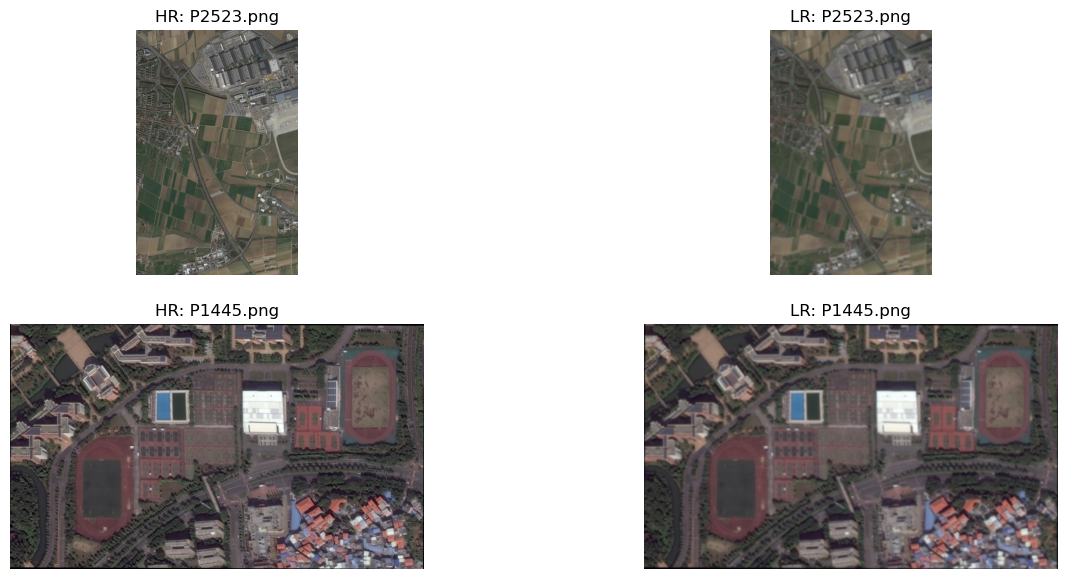

In [17]:

# Function to display HR and LR images side by side
def display_hr_lr_comparison(hr_directory, lr_directory, n=2):
    hr_files = random.sample([file for file in os.listdir(hr_directory) if os.path.isfile(os.path.join(hr_directory, file))], n)
    plt.figure(figsize=(15, 7))
    for i, file in enumerate(hr_filesdddd):
        with Image.open(os.path.join(hr_directory, file)) as hr_img, Image.open(os.path.join(lr_directory, file)) as lr_img:
            plt.subplot(n, 2, 2*i + 1)
            plt.imshow(hr_img)
            plt.axis('off')
            plt.title(f'HR: {file}')
            
            plt.subplot(n, 2, 2*i + 2)
            plt.imshow(lr_img)
            plt.axis('off')
            plt.title(f'LR: {file}')
    plt.show()

display_hr_lr_comparison(train_hr_path, train_lr_path, n=2)

### Quantitative Metrics: PSNR

In [23]:
# Function to calculate PSNR
def calculate_psnr(hr_image, lr_image):
    mse = np.mean((hr_image - lr_image) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
                 # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

# Function to get average PSNR for a set of images
def get_average_psnr(hr_directory, lr_directory, n=10):
    psnrs = []
    hr_files = random.sample([file for file in os.listdir(hr_directory) if os.path.isfile(os.path.join(hr_directory, file))], n)
    for file in hr_files:
        with Image.open(os.path.join(hr_directory, file)) as hr_img, Image.open(os.path.join(lr_directory, file)) as lr_img:
            hr_img_array = np.array(hr_img)
            lr_img_resized = lr_img.resize(hr_img.size, Image.BICUBIC)
            lr_img_array = np.array(lr_img_resized)
            psnr = calculate_psnr(hr_img_array, lr_img_array)
            psnrs.append(psnr)
    return np.mean(psnrs)

average_psnr = get_average_psnr(train_hr_path, train_lr_path)
print(f'Average PSNR between HR and LR images: {average_psnr} dB')

Average PSNR between HR and LR images: 33.84169602949733 dB


### Training EDSRModel

In [31]:
def load_image_pair(lr_path, hr_path):
    # Load the images
    lr_image = tf.io.read_file(lr_path)
    lr_image = tf.image.decode_png(lr_image, channels=3)
    lr_image = tf.image.convert_image_dtype(lr_image, tf.float32)  # Convert to float32

    hr_image = tf.io.read_file(hr_path)
    hr_image = tf.image.decode_png(hr_image, channels=3)
    hr_image = tf.image.convert_image_dtype(hr_image, tf.float32)  # Convert to float32

    return lr_image, hr_image
def create_dataset(lr_dir, hr_dir):
    # List all files in the low-res and high-res directories
    lr_image_paths = sorted([os.path.join(lr_dir, x) for x in os.listdir(lr_dir)])
    hr_image_paths = sorted([os.path.join(hr_dir, x) for x in os.listdir(hr_dir)])
    
    # Create a TensorFlow dataset from the file paths
    dataset = tf.data.Dataset.from_tensor_slices((lr_image_paths, hr_image_paths))
    
    # Map the load_image_pair function to each element in the dataset
    dataset = dataset.map(lambda lr, hr: load_image_pair(lr, hr), num_parallel_calls=tf.data.AUTOTUNE)
    
    return dataset

# Paths to your dataset folders
dataset_path = "./dataset/"
train_hr_path = os.path.join(dataset_path, "train_hr")
train_lr_path = os.path.join(dataset_path, "train_lr")
val_hr_path = os.path.join(dataset_path, "val_hr")
val_lr_path = os.path.join(dataset_path, "val_lr")
test_hr_path = os.path.join(dataset_path, "test_hr")
test_lr_path = os.path.join(dataset_path, "test_lr")

# Create datasets
train_dataset = create_dataset(train_lr_path, train_hr_path)
val_dataset = create_dataset(val_lr_path, val_hr_path)
test_dataset = create_dataset(test_lr_path, test_hr_path)
train_dataset_cache = train_dataset.cache()
val_dataset_cache = val_dataset.cache()
test_dataset_cache = test_dataset.cache()

In [14]:
def plot_image_pair(lr_image, hr_image, index):
    lr_image = lr_image.numpy()
    hr_image = hr_image.numpy()

    # Get image resolutions
    lr_resolution = lr_image.shape[:2]
    hr_resolution = hr_image.shape[:2]

    # Plot the images
    plt.figure(figsize=(10, 5))

    # Plot Low-Resolution Image
    plt.subplot(1, 2, 1)
    plt.imshow(lr_image)
    plt.title(f"Low-Resolution ({lr_resolution[1]}x{lr_resolution[0]})")
    plt.axis('off')

    # Plot High-Resolution Image
    plt.subplot(1, 2, 2)
    plt.imshow(hr_image)
    plt.title(f"High-Resolution ({hr_resolution[1]}x{hr_resolution[0]})")
    plt.axis('off')

    plt.suptitle(f"Image Pair {index + 1}")
    plt.show()


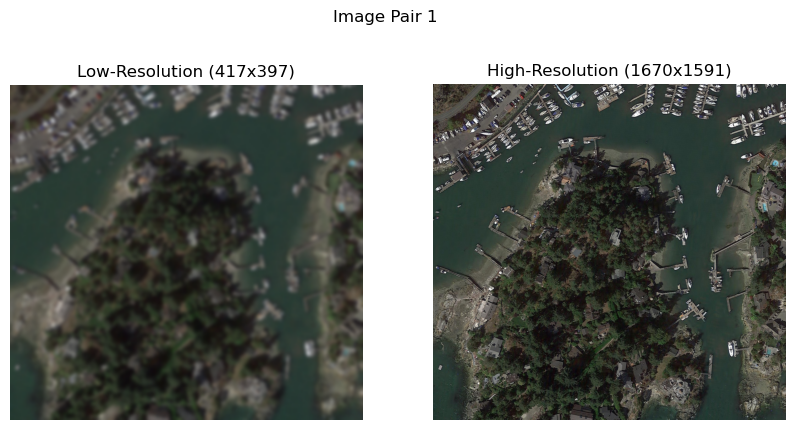

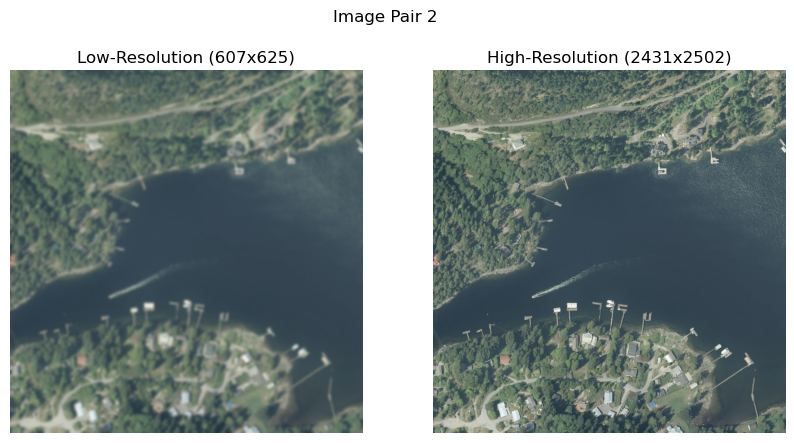

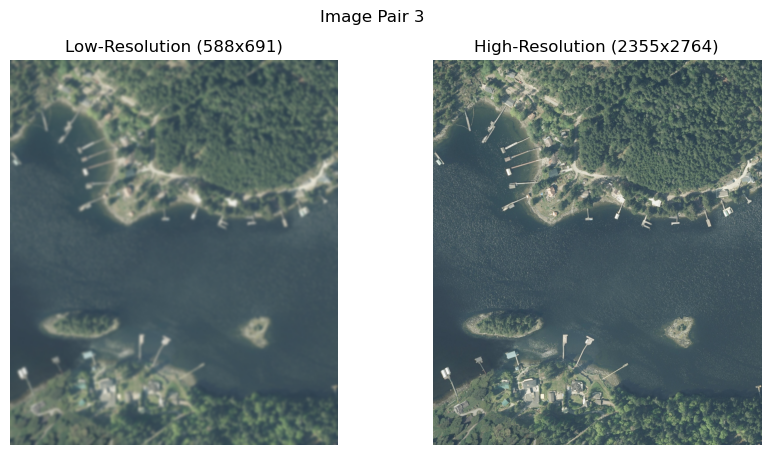

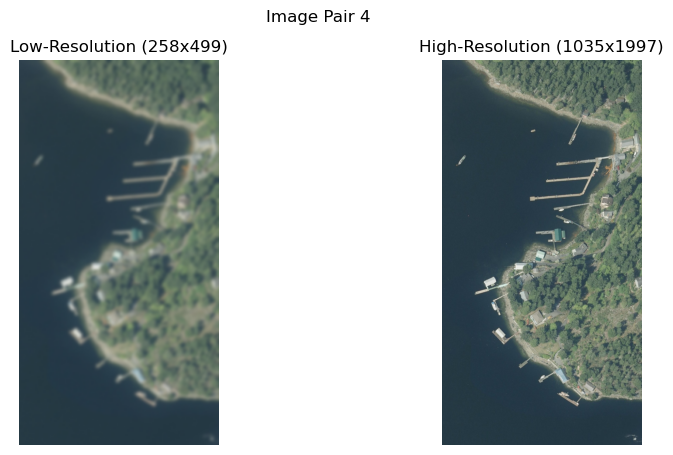

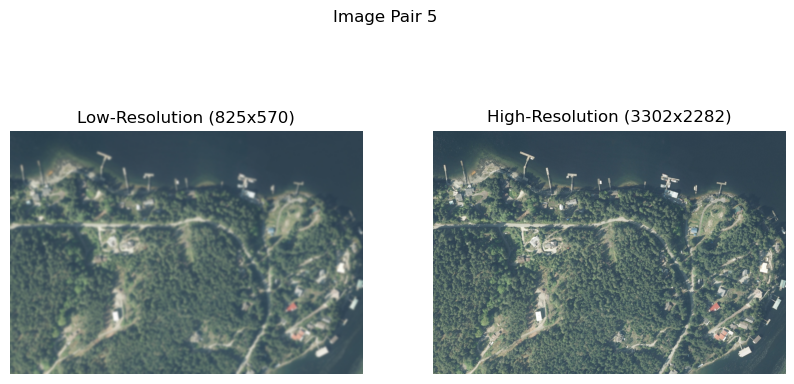

In [18]:
# Iterate through the first few images in the train dataset
for index, (lr_image, hr_image) in enumerate(train_dataset_cache.take(5)):
    plot_image_pair(lr_image, hr_image, index)


In [32]:
# Resize LR to 64x64 and HR to 256x256
def resize_images(lr_image, hr_image, lr_target_size=(64, 64), hr_target_size=(256, 256)):
    lr_image = tf.image.resize(lr_image, lr_target_size)
    hr_image = tf.image.resize(hr_image, hr_target_size)
    return lr_image, hr_image

def dataset_object(dataset_cache, training=True, lr_target_size=(64, 64), hr_target_size=(256, 256)):
    ds = dataset_cache

    # Resize images to match model input and output size
    ds = ds.map(lambda lr, hr: resize_images(lr, hr, lr_target_size=lr_target_size, hr_target_size=hr_target_size), num_parallel_calls=tf.data.AUTOTUNE)

    # Batching Data
    ds = ds.batch(1)

    if training:
        ds = ds.repeat()

    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

# Prepare datasets with correct sizes
train_ds = dataset_object(train_dataset_cache, training=True)
val_ds = dataset_object(val_dataset_cache, training=False)
test_ds = dataset_object(test_dataset_cache, training=False)

def PSNR(y_true, y_pred):
    # Ensure the pixel values are within the correct range
    max_pixel = 255.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [33]:
class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        # Ensure x has shape (batch_size, height, width, channels)
        if len(x.shape) == 3:
            # Add a batch dimension using tf.expand_dims if the input is (height, width, channels)
            x = tf.expand_dims(x, axis=0)
        # Cast to float32 for processing
        x = tf.cast(x, tf.float32)
        # Passing low resolution image to model
        super_resolution_img = self(x, training=False)
        # Remove the batch dimension after processing
        super_resolution_img = tf.squeeze(super_resolution_img, axis=0)
        # Clips the tensor from min(0) to max(255)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        # Rounds the values of a tensor to the nearest integer
        super_resolution_img = tf.round(super_resolution_img)
        # Convert to uint8 for visualization
        super_resolution_img = tf.cast(super_resolution_img, tf.uint8)
        return super_resolution_img

# Residual Block
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x


def make_model(num_filters, num_of_residual_blocks):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)


model = make_model(num_filters=64, num_of_residual_blocks=4)

In [1]:
# Using adam optimizer with initial learning rate as 1e-4, changing learning rate after 5000 steps to 5e-5
optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)
# Compiling model with loss as mean absolute error(L1 Loss) and metric as psnr
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])
# Training for more epochs will improve results
history = model.fit(train_ds, epochs=50, steps_per_epoch=2034, validation_data=val_ds)

Epoch 1/50
2034/2034 [==============================] - 872s 123ms/step - loss: 1.5438 - psnr_metric: 16.4538 - val_loss: 1.8465 - val_psnr_metric: 13.3290
Epoch 2/50
2034/2034 [==============================] - 872s 123ms/step - loss: 1.6172 - psnr_metric: 17.2375 - val_loss: 2.3693 - val_psnr_metric: 14.0733
Epoch 3/50
2034/2034 [==============================] - 872s 123ms/step - loss: 1.6379 - psnr_metric: 18.1221 - val_loss: 1.9656 - val_psnr_metric: 12.5616
Epoch 4/50
2034/2034 [==============================] - 872s 123ms/step - loss: 1.4673 - psnr_metric: 19.8542 - val_loss: 1.7952 - val_psnr_metric: 13.7834
Epoch 5/50
2034/2034 [==============================] - 872s 123ms/step - loss: 1.1444 - psnr_metric: 17.5657 - val_loss: 2.1003 - val_psnr_metric: 12.8976
Epoch 6/50
2034/2034 [==============================] - 872s 123ms/step - loss: 1.6445 - psnr_metric: 16.9823 - val_loss: 1.4481 - val_psnr_metric: 15.4512
Epoch 7/50
2034/2034 [==============================] - 872s 123

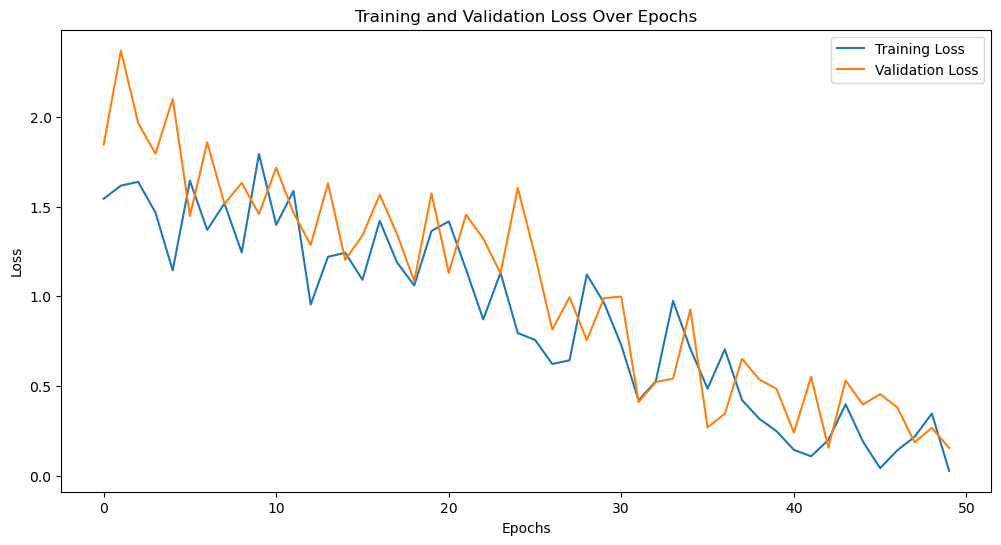

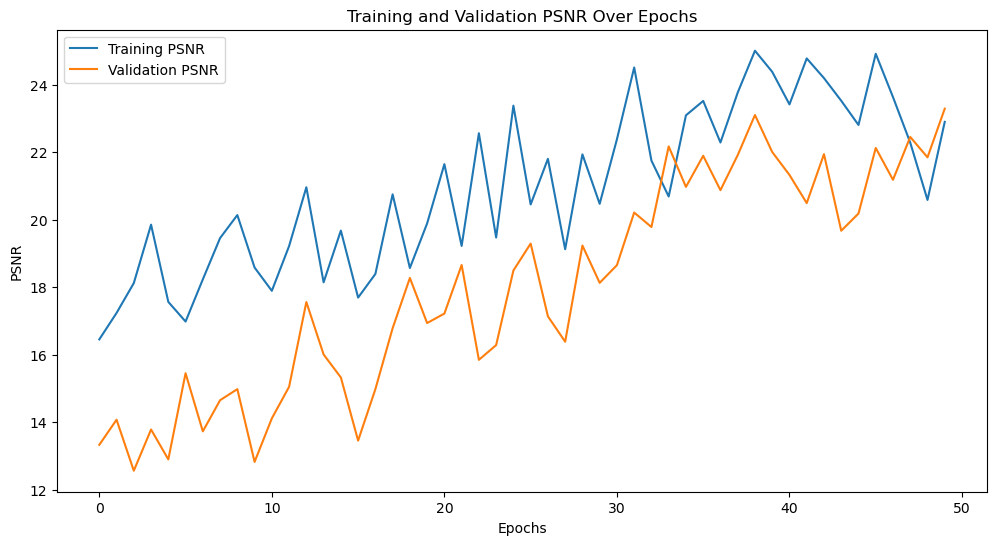

In [4]:
plt.figure(figsize=(12, 6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plr.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['psnr_metric'], label='Training PSNR')
plt.plot(history.history['val_psnr_metric'], label='Validation PSNR')
plt.title('Training and Validation PSNR Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()
plr.show()

In [3]:
def evaluate_model(model, dataset):
    psnr_values = []
    ssim_values = []
    
    for lowres, highres in dataset:
        # Predict the super-resolution image
        preds = model.predict_step(lowres)
        
        # Ensure the predicted and high-resolution images have the same scale [0, 255]
        highres = tf.squeeze(highres, axis=0) if len(highres.shape) == 4 else highres
        preds = tf.squeeze(preds, axis=0) if len(preds.shape) == 4 else preds
        
        if preds.dtype != tf.uint8:
            preds = tf.clip_by_value(preds, 0, 1)
            preds = tf.cast(preds * 255, tf.uint8)
        
        if highres.dtype != tf.uint8:
            highres = tf.clip_by_value(highres, 0, 1)
            highres = tf.cast(highres * 255, tf.uint8)
        
        # Compute PSNR
        psnr = tf.image.psnr(highres, preds, max_val=255)
        psnr_values.append(psnr.numpy())
        
        # Compute SSIM
        loss = tf.image.loss(highres, preds, max_val=255)
        loss_values.append(loss.numpy())
    
    # Average the PSNR and SSIM values over all samples
    avg_psnr = np.mean(psnr_values)
    avg_loss = np.mean(loss_values)
    
    return avg_psnr, avg_loss

# Assuming 'val_ds' is your validation dataset
avg_psnr, avg_loss = evaluate_model(model, test_ds)
print(f"Average PSNR: {avg_psnr:.2f}")
print(f"Average Loss: {avg_loss:.4f}")


Average PSNR: 23.83
Average Loss: 0.3425
